# Momentum Strategies Experiments

Using SP500 data to create strategies around momentum (n-day means)

In [13]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 13,8
import seaborn as sns
import pandas as pd

#### Dataset:  daily prices of for market representative such as S&P 500, MSCI World, etc. ####

In [148]:
#use temp.py to obtain individual stock data
path = r'./individual_stocks/' # use your path
all_files = glob.glob(path + "*.csv")

li = []
cols = []
for filename in all_files[:]:
    df = pd.read_csv(filename, index_col=0, header=0, date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
    df = df.Close
    cols.append(filename.partition("_")[-1].partition("_")[0].strip("stocks/"))
    li.append(df)
n_stocks_show = 12
frame = pd.concat(li, axis=1, ignore_index=True)
frame = frame.rename(columns=dict(zip(range(len(all_files)), cols)))
asset_prices = frame.interpolate().fillna(method="ffill").fillna(method="bfill")
print('Asset prices shape', asset_prices.shape)
display(asset_prices.iloc[:, :n_stocks_show].head(-3))
asset_prices.columns

Asset prices shape (3777, 506)


,GS,SPGI,MTB,V,CTAS,ZBRA,BRO,APH,RHI,HCA,HD,PEP
Date,,,,,,,,,,,,
2007-02-14,217.399994,68.070000,124.029999,14.125000,42.369999,37.970001,14.215000,8.443750,41.330002,31.020000,41.730000,63.349998
2007-02-15,216.820007,67.690002,124.129997,14.125000,42.340000,39.990002,14.335000,8.433750,41.240002,31.020000,41.660000,64.080002
2007-02-16,216.919998,68.580002,124.419998,14.125000,42.389999,40.830002,14.310000,8.372500,41.430000,31.020000,41.439999,64.620003
2007-02-20,220.940002,68.610001,124.739998,14.125000,42.810001,41.080002,14.220000,8.490000,41.180000,31.020000,41.340000,64.610001
2007-02-21,220.149994,68.650002,124.550003,14.125000,42.470001,41.599998,14.140000,8.490000,41.340000,31.020000,41.299999,65.019997
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-02,363.059998,422.070007,175.820007,235.419998,391.450012,517.010010,68.080002,80.449997,117.000000,240.789993,373.730011,175.470001
2022-02-03,358.880005,413.149994,175.179993,231.539993,385.079987,508.299988,66.639999,79.070000,116.059998,240.860001,364.809998,175.369995
2022-02-04,367.600006,414.390015,179.559998,228.389999,381.809998,503.089996,67.529999,78.760002,118.360001,239.080002,359.670013,172.490005


Index(['GS', 'SPGI', 'MTB', 'V', 'CTAS', 'ZBRA', 'BRO', 'APH', 'RHI', 'HCA',
       ...
       'HAL', 'CERN', 'SJM', 'WY', 'WFC', 'QCOM', 'TFX', 'COF', 'MSCI', 'F'],
      dtype='object', length=506)

### Calculate daily log-returns

In [149]:
asset_returns = np.log(asset_prices) - np.log(asset_prices.shift(1))
#asset_returns = asset_prices.pct_change(periods=1) #log(1+r) approx r
asset_returns = asset_returns.iloc[1:, :]


In [150]:
offset = "01-01-2008"
symbol="VOO"
short = 21
long = 251
safe_rate = 0.01 #safe annual interest rate

## Create safe asset return virtually

In [151]:
asset_returns["SAFE"]=np.log((1+safe_rate/251))

Date
2007-02-15    0.000000
2007-02-16    0.000000
2007-02-20    0.000000
2007-02-21    0.000000
2007-02-22    0.000000
                ...   
2022-02-07   -0.003302
2022-02-08    0.008066
2022-02-09    0.014562
2022-02-10   -0.017728
2022-02-11   -0.020144
Name: VOO, Length: 3776, dtype: float64

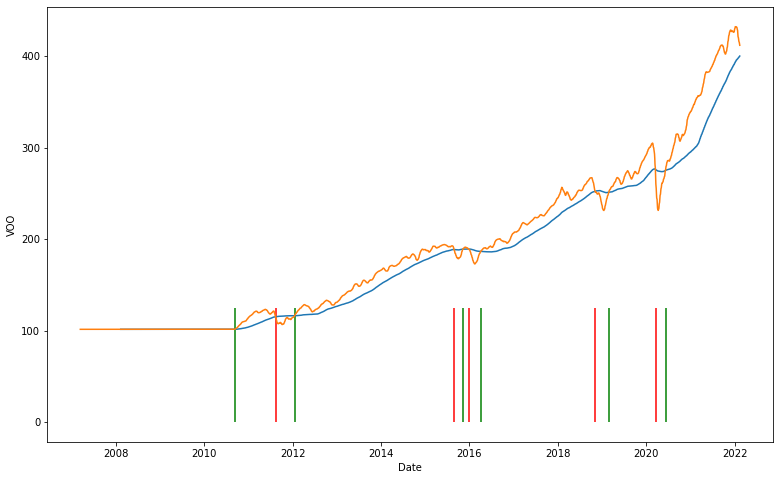

In [152]:
sns.lineplot(data=asset_prices[symbol].rolling(long).mean())
sns.lineplot(data=asset_prices[symbol].rolling(short).mean())

def create_signal(assetA, assetB):
    long_asset = assetA.copy()
    short_asset = assetB.copy()
    diving_dates = []
    surging_dates = []
    for pos, date in enumerate(long_asset.index[1:]) :
        if (long_asset.iloc[pos] > short_asset.iloc[pos]) and (long_asset.iloc[pos-1] <= short_asset.iloc[pos-1] ):
            diving_dates.append(date)
        if (long_asset.iloc[pos] < short_asset.iloc[pos]) and (long_asset.iloc[pos-1] >= short_asset.iloc[pos-1] ):
            surging_dates.append(date)
    return diving_dates, surging_dates

dips, hips = create_signal(asset_prices[symbol].rolling(251).mean(), asset_prices[symbol].rolling(21).mean())

plt.vlines(x=dips, ymin=0, ymax=125, color="r")
plt.vlines(x=hips, ymin=0, ymax=125, color="g")

asset_returns[symbol]
    

In [153]:
def get_weight(index, hips, dips):
    '''
    Calculate EQ / FI portfolio weights based on Absorption Ratio delta
    Arguments:
    ar_delta -- Absorption Ratio delta
    
    Return: 
        wgts -- a vector of portfolio weights
    '''
    weights = pd.DataFrame(index=index, columns=["EQ", "FI"])
    old_EQ = 0.6
    old_FI = 0.4
    for date in index:
        if date in hips:
            weights.EQ[date] = 1.0
            weights.FI[date] = 0.0
        elif date in dips:
            weights.EQ[date] = 0.0
            weights.FI[date] = 1.0
        else:
            weights.EQ[date] = old_EQ
            weights.FI[date] = old_FI
        old_EQ = weights.EQ[date]
        old_FI = weights.FI[date]
    return weights

weights = get_weight(asset_returns[symbol].index, hips, dips)
    

## Defining a trading strategy from n-day averages to capture momenta

## Backtesting

In [154]:
def backtest_strategy(strat_wgts, asset_returns, periods_per_year = 252):
    '''
    Calculate portfolio returns and return portfolio strategy performance
    Arguments:
    
    strat_wgts -- pandas.DataFrame of weights of the assets
    asset_returns -- pandas.DataFrame of asset returns
    periods_per_year -- number of return observations per year
    
    Return: 
        (ann_ret, ann_vol, sharpe) -- a tuple of (annualized return, annualized volatility, sharpe ratio)
    '''
    
    together = pd.merge(strat_wgts, asset_returns, left_index=True, right_index=True)
    together["Returns"] = together["EQ"]*together["EQ_RETURN"]+together["FI"]*together["FI_RETURN"]
    annualized_return = np.prod(together.Returns.values + 1)**(periods_per_year/len(together.Returns))-1
    annualized_volatility = together.Returns.std() * np.sqrt(periods_per_year)
    return annualized_return, annualized_volatility, annualized_return/annualized_volatility

In [155]:
etf_r = asset_returns.filter([symbol,'SAFE'], axis=1)
display(etf_r)
etf_r.rename(columns={symbol:"EQ_RETURN", "SAFE":"FI_RETURN"}, inplace=True)
ann_ret, ann_vol, sharpe = backtest_strategy(weights[offset:], etf_r[offset:])
print('Strategy:', ann_ret, ann_vol, sharpe)
eq_wgts = weights.copy()
eq_wgts.FI = 0
eq_wgts.EQ = 1
ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt = backtest_strategy(eq_wgts, etf_r)
print('Buy and hold:', ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt)
eq_wgts.FI = 0.4
eq_wgts.EQ = 0.6
ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt = backtest_strategy(eq_wgts, etf_r)
print('Classic Mix:', ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt)

,VOO,SAFE
Date,,
2007-02-15,0.000000,0.00004
2007-02-16,0.000000,0.00004
2007-02-20,0.000000,0.00004
2007-02-21,0.000000,0.00004
2007-02-22,0.000000,0.00004
...,...,...
2022-02-07,-0.003302,0.00004
2022-02-08,0.008066,0.00004
2022-02-09,0.014562,0.00004


Strategy: 0.06629453950097641 0.12885368885086887 0.5144946962108596
Buy and hold: 0.08474975009452379 0.1484942678983704 0.570727417926506
Classic Mix: 0.05707246393440357 0.08909656073902228 0.6405686533914335


## show graphicaly the portfolio vs. equity

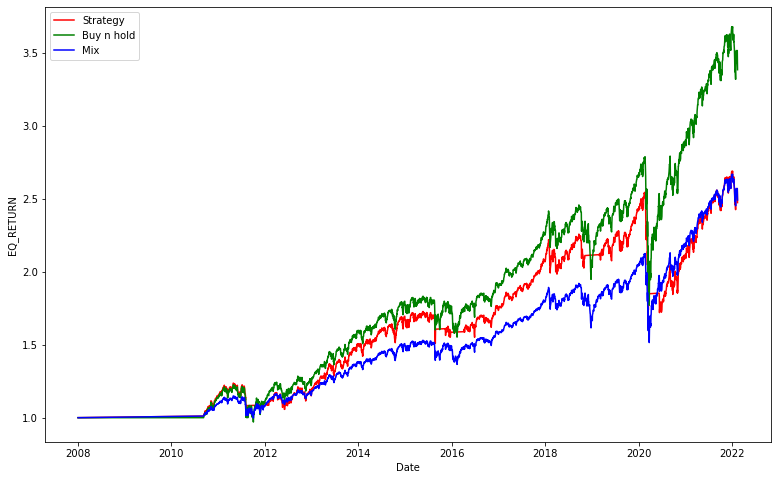

In [156]:
port_r = weights.EQ * etf_r.EQ_RETURN + weights.FI * etf_r.FI_RETURN
port_r = port_r[offset:]
sns.lineplot(data=np.cumprod(1+port_r), color="r", label="Strategy")
sns.lineplot(data=np.cumprod(1+etf_r.EQ_RETURN[offset:]), color="g", label="Buy n hold")
sns.lineplot(data=0.6*np.cumprod(1+etf_r.EQ_RETURN[offset:])+0.4*np.cumprod(1+etf_r.FI_RETURN[offset:]), color="b", label="Mix")
plt.legend()
